# Skin Cancer Classification

In this mini project, we will design an algorithm that can visually diagnose <a href="http://www.skincancer.org/skin-cancer-information/melanoma" target="_blank">melanoma</a>,
 the deadliest form of skin cancer.  In particular, our algorithm will 
distinguish this malignant skin tumor from two types of benign lesions (<a href="http://missinglink.ucsf.edu/lm/dermatologyglossary/nevus.html" target="_blank">nevi</a> and <a href="https://www.aad.org/public/diseases/bumps-and-growths/seborrheic-keratoses" target="_blank">seborrheic keratoses</a>). </p>
<p>The data and objective are pulled from the <a href="https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a" target="_blank">2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection</a>.

As part of the challenge, participants were tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases (melanoma, nevus, or seborrheic keratosis). 

<img src="skin-disease-classes.png" width=90% />

Here, to perform the image classification we use transfer learning to classify skin cancer images using pretrained network [Inception v3](https://pytorch.org/docs/0.3.0/torchvision/models.html#inception-v3).

Data can be downloaded:
[training data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip) (5.3 GB).
[validation data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip) (824.5 MB).
[test data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip) (5.1 GB).


## Set up google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## Download data - uncomment the following lines
#!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip

In [ ]:
## Unzip data - uncomment the following lines
#target_path = '/content/drive/My\ Drive/Colab\ Notebooks/dermatologist-ai/data/'
#src_zipfile = '/content/test.zip'

#!unzip -uq $src_zipfile 'test/*' -d $target_path

## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Load / Preprocessing input data (images)

In [3]:
## data directory in colab
dir_path = '/content/drive/My Drive/Colab Notebooks/dermatologist-ai/'
## data directory in local machine
#dir_path = './'

files_path = dir_path + 'data/'

transform = {
    'train': transforms.Compose([transforms.RandomRotation((0,359)),
                                 transforms.RandomVerticalFlip(),
                                 transforms.Resize(380),
                                 transforms.CenterCrop(299),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
    
    'valid': transforms.Compose([transforms.Resize(300),
                                 transforms.CenterCrop(299),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
    
    'test':  transforms.Compose([transforms.Resize(300),
                                 transforms.CenterCrop(299),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ])
}

dataset = {
    'train': datasets.ImageFolder(files_path + 'train', transform=transform['train']),
    'valid': datasets.ImageFolder(files_path + 'valid', transform=transform['valid']),
    'test' : datasets.ImageFolder(files_path + 'test' , transform=transform['test'])
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=128, shuffle=True),
    'valid': torch.utils.data.DataLoader(dataset['valid'], batch_size=64, shuffle=False),
    'test':  torch.utils.data.DataLoader(dataset['test'],  batch_size=64, shuffle=False)
}

classes = dataset['train'].classes
n_classes = len(classes)

In [4]:
## test dataset size 
print('Size of data sets \tTrain: {:4d}\tValidation: {:4d}\tTest: {:3d}'.format(len(dataset['train']), len(dataset['valid']), len(dataset['test'])))
print('Size of data loaders \tTrain: {:4d}\tValidation: {:4d}\tTest: {:3d}'.format(len(dataloader['train']), len(dataloader['valid']), len(dataloader['test'])))
print('Number of classes: ', n_classes)
print('Classes: ', classes)

Size of data sets 	Train: 2000	Validation:  150	Test: 600
Size of data loaders 	Train:   16	Validation:    3	Test:  10
Number of classes:  3
Classes:  ['melanoma', 'nevus', 'seborrheic_keratosis']


## Data visualization

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """
    Imshow for Tensor.
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

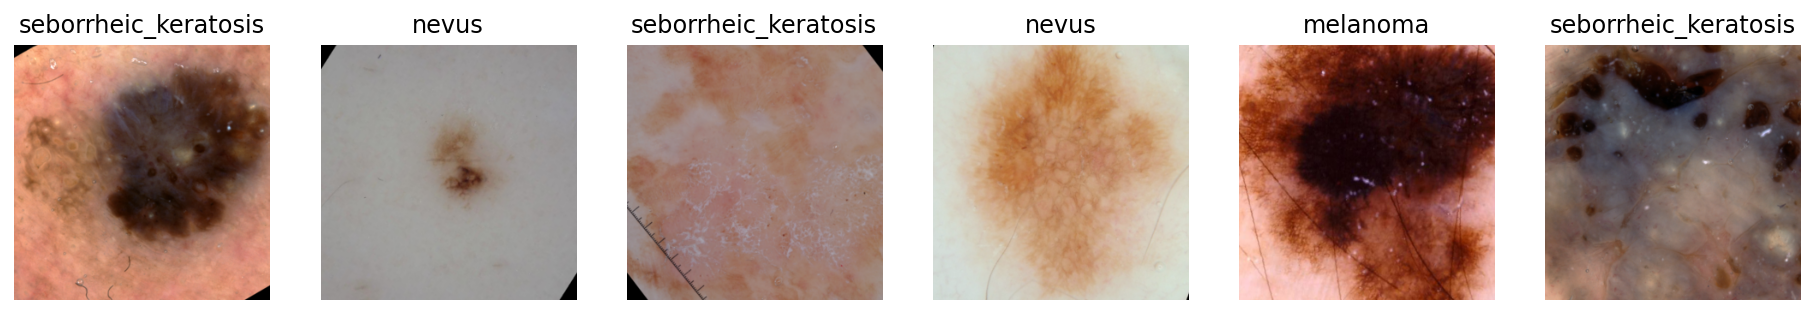

In [6]:
## test visualizing samples

images, labels = next(iter(dataloader['train']))

n_sample_images = 6

fig, axis = plt.subplots(ncols=n_sample_images, figsize=(16,4))
for ii in range(n_sample_images):
    ax = axis[ii]
    imshow(images[ii], ax=ax)
    ax.set_title(classes[labels[ii]], fontsize=12)

## Load pretrained model

In [7]:
#model = models.inception_v3(pretrained=True, aux_logits=False)
model = models.resnet152(pretrained=True)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Setup pretrained model

In [8]:
for para in model.parameters():
    para.requires_grad = False

classifier_input = 2048
classifier_hidden = 512

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(classifier_input, classifier_hidden, bias=False)),
    ('bn1', nn.BatchNorm1d(classifier_hidden)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(classifier_hidden, n_classes)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

model.fc = classifier
#model.classifier[6] = classifier

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Check for cuda

In [9]:
use_cuda = torch.cuda.is_available()

device = torch.device('cuda' if use_cuda else 'cpu')
print('device:', device)

model = model.to(device)

device: cuda


### Number of trainable parameters

In [10]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total number of parameters: {}\nTrainable parameters: {}'.format(pytorch_total_params, pytorch_train_params))

Total number of parameters: 59194947
Trainable parameters: 1051139


### Model criterion and optimizer

In [11]:
criterion = nn.NLLLoss()

optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0., weight_decay=1e-5)
#optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

## Train and Validate the Model

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(epochs, dataloader, model, optimizer, criterion, use_cuda, save_path):
    
    valid_loss_min = np.Inf
    valid_acc_max = 0

    losses = list()
    
    for epoch in range(1, epochs+1):
        
        train_loss = 0

        #==============================
        # train the model
        #==============================

        for batch_idx, (images, labels) in enumerate(dataloader['train']):
            
            model.train()

            if use_cuda:
                images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += (loss.item() - train_loss) / (batch_idx + 1)
            
            #==============================
            # validate the model
            #==============================
            with torch.no_grad():

                valid_loss = 0
                valid_correct = 0
                valid_total = 0

                    
                for valid_batch_idx, (valid_images, valid_labels) in enumerate(dataloader['valid']):

                    model.eval()

                    if use_cuda:
                        valid_images, valid_labels = valid_images.cuda(), valid_labels.cuda()

                    valid_outputs = model(valid_images)
                    v_loss = criterion(valid_outputs, valid_labels)

                    valid_loss += (v_loss.item() - valid_loss) / (valid_batch_idx + 1)

                    valid_out_probs = torch.exp(valid_outputs.data)
                    _, preds = valid_out_probs.max(dim=1, keepdim=True)

                    valid_correct += np.sum(np.squeeze(preds.eq(valid_labels.data.view_as(preds))).cpu().numpy())
                    valid_total += valid_images.size(0)

                accuracy = valid_correct / valid_total

            #========================================
            # print training/validation statistics
            #========================================
            print('Epoch: {:2d}/{:2d}\tBatch:{:2d}/{:2d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, epochs, batch_idx+1, len(dataloader['train']), train_loss, valid_loss), end='')
            
            losses.append([train_loss, valid_loss, accuracy])
            
            #==================================================
            # save the model if validation loss has decreased
            #==================================================
            if valid_loss < valid_loss_min:
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss
                print('\tModel saved ...')
            else:
                print('')
            
            #==================================================
            # save the model for maximum valid accuracy
            #==================================================
            if accuracy > valid_acc_max:
                torch.save(model.state_dict(), dir_path + 'model_acc.pt')
                valid_acc_max = accuracy
        
        scheduler.step()
    
    return model, losses


In [13]:
n_epochs = 2

model, losses = train(n_epochs, dataloader, model, optimizer, criterion, use_cuda, dir_path + 'model.pt')

Epoch:  1/ 2	Batch: 1/16 	Training Loss: 0.583601 	Validation Loss: 0.871783	Model saved ...
Epoch:  1/ 2	Batch: 2/16 	Training Loss: 0.530671 	Validation Loss: 1.106757
Epoch:  1/ 2	Batch: 3/16 	Training Loss: 0.527297 	Validation Loss: 1.104256
Epoch:  1/ 2	Batch: 4/16 	Training Loss: 0.539659 	Validation Loss: 0.857617	Model saved ...
Epoch:  1/ 2	Batch: 5/16 	Training Loss: 0.530561 	Validation Loss: 0.977981
Epoch:  1/ 2	Batch: 6/16 	Training Loss: 0.528771 	Validation Loss: 0.749868	Model saved ...
Epoch:  1/ 2	Batch: 7/16 	Training Loss: 0.529591 	Validation Loss: 0.841939
Epoch:  1/ 2	Batch: 8/16 	Training Loss: 0.529233 	Validation Loss: 0.784957
Epoch:  1/ 2	Batch: 9/16 	Training Loss: 0.535264 	Validation Loss: 0.805098
Epoch:  1/ 2	Batch:10/16 	Training Loss: 0.538938 	Validation Loss: 0.783073
Epoch:  1/ 2	Batch:11/16 	Training Loss: 0.541804 	Validation Loss: 0.884144
Epoch:  1/ 2	Batch:12/16 	Training Loss: 0.538091 	Validation Loss: 0.922912
Epoch:  1/ 2	Batch:13/16 	Tr

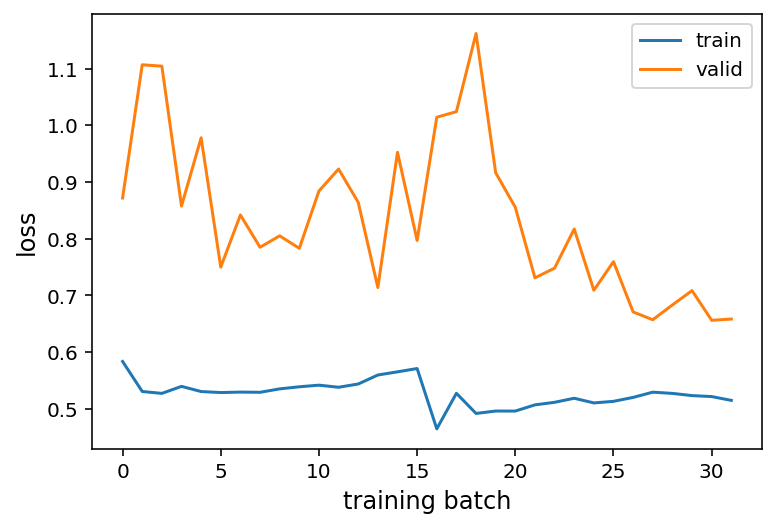

In [14]:
## save losses
losses = np.array(losses)
np.savetxt(dir_path + 'losses.csv', losses, delimiter=',')

## load losses
#losses = np.loadtxt(open("losses.csv", "rb"), delimiter=",")

train_loss, valid_loss = losses[:,0], losses[:,1]

plt.plot(train_loss)
plt.plot(valid_loss)
#plt.plot(losses[:,2])
plt.xlabel('training batch', fontsize=12)
plt.ylabel('loss', rotation=90, fontsize=12)
plt.legend(['train', 'valid'])
plt.show()

## Load the best trained Model for Inference

In [15]:
## load the model that got the best validation accuracy
model.load_state_dict(torch.load(dir_path + 'model.pt', map_location=torch.device(device)))

## send model to cuda if available
device = torch.device('cuda' if use_cuda else 'cpu')
model = model.to(device)

## Test the Model

In [16]:
def test(dataloader, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        
        model.eval()

        for batch_idx, (images, labels) in enumerate(dataloader['test']):

            if use_cuda:
                images, labels = images.cuda(), labels.cuda()

            output = model(images)
            loss = criterion(output, labels)

            test_loss +=  (loss.data - test_loss) / (batch_idx + 1)
            
            out_probs = torch.exp(output.data)
            _, preds = out_probs.max(dim=1, keepdim=True)

            correct += np.sum(np.squeeze(preds.eq(labels.data.view_as(preds))).cpu().numpy())
            total += images.size(0)
        
        accuracy = correct / total

        print('Test Loss: {:.6f}\n'.format(test_loss))
        
        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100. * accuracy, correct, total))
    
    return accuracy, test_loss


In [17]:
accuracy, test_loss = test(dataloader, model, criterion, use_cuda)

Test Loss: 0.647172


Test Accuracy: 75% (450/600)


## Predict

In [18]:
def predict(image):
    
    with torch.no_grad():
        
        model.eval()
        
        image = torch.unsqueeze(image,0)
        
        output = model.forward(image)
        out_prob = torch.exp(output)
        _, class_idx = torch.max(out_prob, dim=1)
        
    return classes[class_idx]

In [19]:
## test predict function
iterator = iter(dataloader['test'])
images, labels = iterator.next()
images, labels = images.to(device), labels.to(device)

Predicted: seborrheic_keratosis


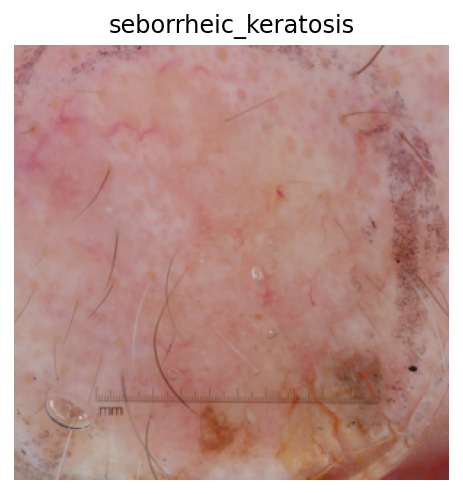

In [20]:
idx = np.random.randint(len(images))
image = images[idx]
label = labels[idx]

print('Predicted: {}'.format(predict(image)))

imshow(image.cpu())
plt.title(classes[label])
plt.show()

## Prediction probabilities

In [21]:
def predictions(dataloader, model, use_cuda):
    """
    Prediction probabilities of three different classes for test set
    """
    with torch.no_grad():
        
        model.eval()
        
        predicts = list()
        
        for images, labels in dataloader['test']:
            
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            
            outputs = model(images)
            preds = torch.exp(outputs.data).tolist()
            predicts.extend(preds)
        
    return predicts

### Model's predicted probabilities<br>
task_1 - the model's predicted probability that the image (at the path in Id) depicts melanoma<br>
task_2 - the model's predicted probability that the image (at the path in Id) depicts seborrheic keratosis

In [22]:
predicts = predictions(dataloader, model, use_cuda)

predicts = np.array(predicts)

task_1, task_2 = predicts[:,0], predicts[:,2]

In [23]:
import csv

with open(dir_path + 'probs_predicts.csv', mode='w', newline='') as csv_file:
    
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['P0', 'P1', 'P2'])
    
    for idx in range(predicts.shape[0]):
        csv_writer.writerow(predicts[idx].tolist())

In [24]:
import pandas as pd

df = pd.read_csv(dir_path + 'probs_predicts.csv')
df.to_numpy()

array([[2.75493979e-01, 6.22910917e-01, 1.01595059e-01],
       [5.57079539e-02, 3.76464128e-01, 5.67827880e-01],
       [6.35848880e-01, 3.09895873e-01, 5.42552322e-02],
       ...,
       [3.19331069e-04, 1.77479107e-02, 9.81932640e-01],
       [3.15314531e-02, 1.00565858e-01, 8.67902696e-01],
       [4.14360175e-03, 4.57803868e-02, 9.50075924e-01]])

### Create files path list<br>
Id - the file names of the test images.

In [25]:
data = dataset['test']
paths = data.imgs

img_paths = list()

for path, _ in paths:
    img_paths.append(path)

## test image path
img_paths[0]

'/content/drive/My Drive/Colab Notebooks/dermatologist-ai/data/test/melanoma/ISIC_0012258.jpg'

### Save predictions in csv file<br>
Create a CSV file to store the test predictions.

In [26]:
import csv
        
with open(dir_path + 'predictions.csv', mode='w', newline='') as csv_file:
    
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Id', 'task_1', 'task_2'])
    
    for idx in range(len(img_paths)):
        csv_writer.writerow([img_paths[idx], task_1[idx], task_2[idx]])


## Getting results

In [27]:
import pandas as pd

y_gt = pd.read_csv(dir_path + 'ground_truth.csv')
pred = pd.read_csv(dir_path + 'predictions.csv')

labels = ['task_1', 'task_2']

y_gt = y_gt[labels].values
pred = pred[labels].values

In [28]:
import sys
sys.path.append(dir_path)

import get_results

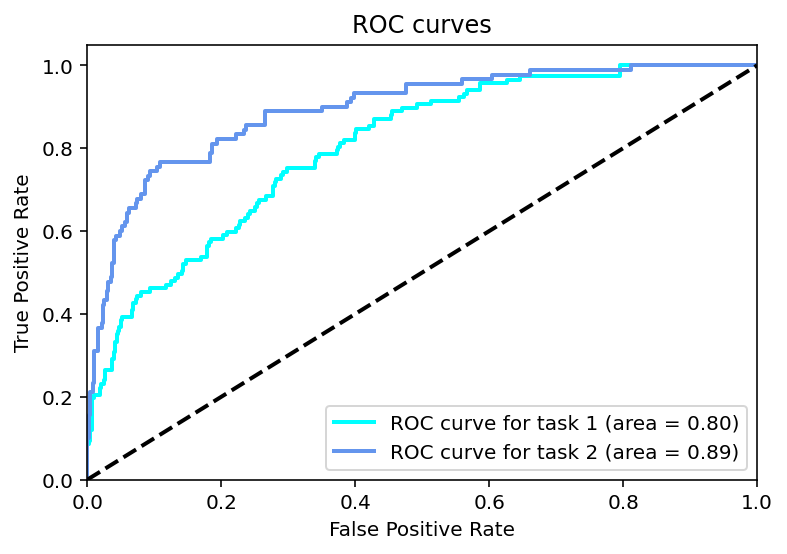

Category 1 Score: 0.804
Category 2 Score: 0.893
Category 3 Score: 0.848


In [29]:
get_results.plot_roc_auc(y_gt, pred)

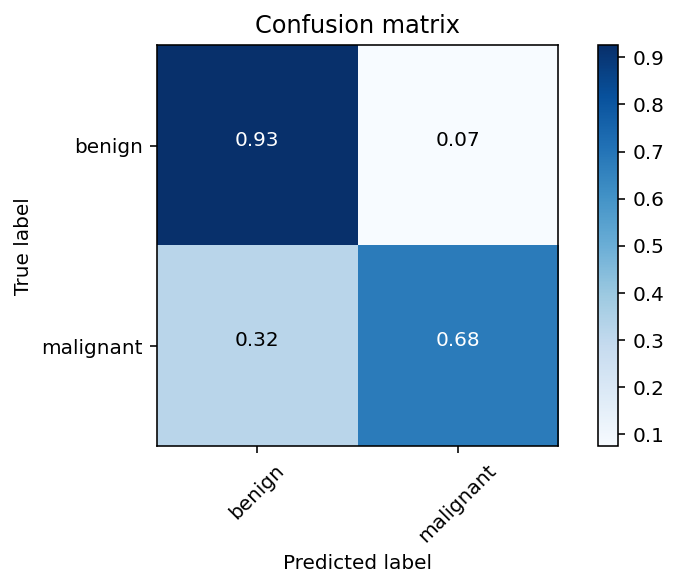

In [30]:
threshold = 0.5
classes = ['benign', 'malignant']

get_results.plot_confusion_matrix(y_gt[:,1], pred[:,1], threshold, classes)